All import need to run the code

In [51]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import cv2
import matplotlib.pyplot as plt
import random

Load dataset from keras cifar10 - https://keras.io/api/datasets/cifar10/

In [52]:
def load_dataset(_amount_of_data=1, _test_ratio=0.2):

    (_training_classes, _training_labels), (_test_classes, _test_labels) = keras.datasets.cifar10.load_data()
    _training_classes, _test_classes = _training_classes / 255.0, _test_classes / 255.0

    _training_classes = _training_classes[:int((_amount_of_data * (1-_test_ratio)))]
    _training_labels = _training_labels[:int((_amount_of_data * (1-_test_ratio)))]
    _test_classes = _test_classes[:int((_amount_of_data * _test_ratio))]
    _test_labels = _test_labels[:int((_amount_of_data * _test_ratio))]

    return (_training_classes, _training_labels), (_test_classes, _test_labels)

Simple function to rescale the images in the dataset.

In [53]:
def rescale_data(_data):
    for pic in range(len(_data)):
       _data[pic]  = cv2.resize(_data[pic], (32,32))
    return _data

Simple function to plot an image using matplotlib, pyplot as plt

In [54]:
def plot_image(_class):
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(_class.reshape(32,32,3))
    plt.show()
    plt.close()

Function to implement bagging for the given dataset. - To read more about bagging, follow this link: https://www.ibm.com/cloud/learn/bagging#:~:text=Bagging%2C%20also%20known%20as%20bootstrap,be%20chosen%20more%20than%20once.

In [55]:
def bagging(_data, _labels, _number_of_bags=3):
    _new_lst = []

    _current_bag = 0
    while _current_bag < _number_of_bags:

        _new_lst.append([])

        _bag_classes = []
        _bag_labels = []

        _count = 0
        while _count < len(_data):
            _index = random.randint(0, len(_data) - 1)
            _bag_classes.append(_data[_index])
            _bag_labels.append(_labels[_index])
            _count += 1

        _new_lst[_current_bag].append(np.array(_bag_classes))
        _new_lst[_current_bag].append(np.array(_bag_labels))

        _current_bag += 1
    return _new_lst

Creates the CNN model.

In [56]:
def create_CNN_model():
        _model = models.Sequential()
        _model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
        _model.add(layers.MaxPooling2D((2, 2)))
        _model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        _model.add(layers.MaxPooling2D((2, 2)))
        _model.add(layers.Conv2D(128, (3, 3), activation='relu'))

        _model.add(layers.Flatten())

        _model.add(layers.Dense(512, activation='relu'))

        _model.add(layers.Dense(256, activation='relu'))
        _model.add(layers.Dropout(0.4))

        _model.add(layers.Dense(128, activation='relu'))

        _model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
        return _model

Function to set up and run the CNN with the bagging technique once.

In [57]:
def run_with_bagging(_training_classes, _training_labels, _test_classes, _test_labels, _number_of_bags=3, _epochs=10):

    _model = create_CNN_model()

    lst = bagging(_training_classes, _training_labels, _number_of_bags)

    _count = 1
    _history = _model.fit(lst[0][0], lst[0][1], epochs=_epochs)

    while _count < _number_of_bags - 1:
        _history = _model.fit(lst[_count][0], lst[_count][1], epochs=_epochs)
        _count += 1

    _history = _model.fit(lst[_count][0], lst[_count][1], epochs=_epochs,
                    validation_data=(_test_classes, _test_labels))

    return _history, _model

Function to set up and run the CNN without the bagging technique once.

In [58]:
def run_without_bagging(_classes, _labels, _test_classes, _test_labels, _epochs=10):

        _model = create_CNN_model()

        _history = _model.fit(_classes, _labels, epochs=_epochs,
                    validation_data=(_test_classes, _test_labels))

        return _history, _model

Simple function to plot the results of any run in a combined graph.

In [59]:
def plot_result(_history, _test_classes, _test_labels, _model):
    plt.plot(_history.history['accuracy'], label='accuracy')
    plt.plot(_history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.1, 1])
    plt.legend(loc='lower right')

    test_loss, test_acc = _model.evaluate(_test_classes,  _test_labels, verbose=2)

Function to run the CNN multiple times with/without bagging.

Epoch 1/10
25/25 [==============================] - 1s 27ms/step - loss: 2.8877 - accuracy: 0.0825 - val_loss: 2.3965 - val_accuracy: 0.0950
Epoch 2/10
25/25 [==============================] - 1s 23ms/step - loss: 2.3720 - accuracy: 0.1238 - val_loss: 2.3278 - val_accuracy: 0.2100
Epoch 3/10
25/25 [==============================] - 1s 22ms/step - loss: 2.1230 - accuracy: 0.1925 - val_loss: 2.0033 - val_accuracy: 0.2400
Epoch 4/10
25/25 [==============================] - 1s 22ms/step - loss: 1.9755 - accuracy: 0.2500 - val_loss: 1.9903 - val_accuracy: 0.2700
Epoch 5/10
25/25 [==============================] - 1s 22ms/step - loss: 1.8726 - accuracy: 0.3000 - val_loss: 1.9272 - val_accuracy: 0.2700
Epoch 6/10
25/25 [==============================] - 1s 22ms/step - loss: 1.8030 - accuracy: 0.3300 - val_loss: 1.9778 - val_accuracy: 0.2600
Epoch 7/10
25/25 [==============================] - 1s 23ms/step - loss: 1.7158 - accuracy: 0.3713 - val_loss: 1.7892 - val_accuracy: 0.3100
Epoch 8/10
25

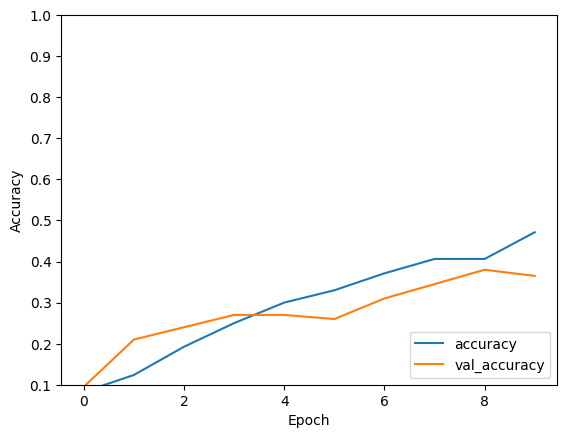

In [60]:
def run_multiple_times(_runs=5, _amount_of_data=1000, _epochs=10):

    _run_count = 0
    while _run_count < _runs:

        (_training_classes, _training_labels), (_test_classes, _test_labels) = load_dataset(_amount_of_data=_amount_of_data)

        _training_labels = np.array(_training_labels.flatten())
        _test_labels = np.array(_test_labels.flatten())

        # Comment in this line to run the CNN without bagging.
        _model_history, _model = run_without_bagging(_training_classes, _training_labels, _test_classes, _test_labels, _epochs=_epochs)

        # Comment in this line to run the CNN with bagging.
        # _model_history, _model = run_with_bagging(_training_classes, _training_labels, _test_classes, _test_labels, _number_of_bags=5, _epochs=_epochs)

        plot_result(_model_history, _test_classes, _test_labels, _model)
        _run_count += 1


# Set these parameters to the desired size of data and amount of runs. Has defaults if forgotten.
run_multiple_times(_runs=1, _amount_of_data=1000, _epochs=10)